# DAMI project (Group 9)
Task:
1. Implementation of DBSCAN algorithm
2. Implementation of DBSCANRN-Tanimoto algorithm (Opt)
3. Clustering quality measures: Purity, Rand, Davies−Bouldin and Silhouette Coefficient 

**PDF report:**
https://www.overleaf.com/6979773668zpthpjhbzqcm

Requirements

```
python==3.8.5
numpy==1.19.5
pandas==1.1.5
matplotlib>=2.1.2
scipy==1.4.1
scikit_learn==0.24.2
tqdm==4.41.1
```

In [263]:
# following libraries are required for this project
import numpy as np                  # array operations
import pandas as pd                 # dataframe operations
import matplotlib.pyplot as plt     # graph visualization
from sklearn import metrics         # evaluation of clustering quality
from sklearn.decomposition import PCA   # for visualizing high dimension dataset
from scipy.io import arff           # reading .arff datasets
from tqdm.notebook import tqdm

# following built-in libraries are required
import time
import os
import operator                     # modifying python ops
from operator import itemgetter     # itemgetter is much faster than lambda

# 1) Code Implementation

## DBSCAN

DBSCAN defines the neighborhood of a data point $o$ by a user specified parameter $\epsilon$,  which includes all data points within this radius from the center of $o$. The density of this $\epsilon$-neighborhood is simply the number of objects in it.

In [262]:
def DBSCAN(Data, eps, MinPts):
    '''
    Cluster the dataset `D` using the DBSCAN algorithm.
    
    dbscan takes a dataset `D` (a list of vectors), a threshold distance
    `eps`, and a required number of points `MinPts`.
    
    It will return a list of cluster labels. The label -1 means noise, and then
    the clusters are numbered starting from 1.
    '''
    t0 = time.time()  # measure operation time

    D = np.asarray(Data)

    # This list will hold the final cluster assignment for each point in D.
    # There are two reserved values:
    #    -1 - Indicates a noise point
    #     0 - Means the point hasn't been considered yet.
    # Initially all labels are 0.    
    labels = [0]*len(D)

    # C is the ID of the current cluster.    
    C = 0
    
    # This outer loop is just responsible for picking new seed points--a point
    # from which to grow a new cluster.
    # Once a valid seed point is found, a new cluster is created, and the 
    # cluster growth is all handled by the 'expandCluster' routine.
    
    # For each point P in the Dataset D...
    # ('P' is the index of the datapoint, rather than the datapoint itself.)

    core = [-1] * len(D) # Type: 1 core, 0 border, -1 noise
  
    for P in range(0, len(D)):
    
        # Only points that have not already been claimed can be picked as new 
        # seed points.    
        # If the point's label is not 0, continue to the next point.
        if not (labels[P] == 0):
            continue
        
        # Find all of P's neighboring points.
        NeighborPts = region_query(D, P, eps)
        
        # If the number is below MinPts, this point is noise. 
        # This is the only condition under which a point is labeled 
        # NOISE--when it's not a valid seed point. A NOISE point may later 
        # be picked up by another cluster as a boundary point (this is the only
        # condition under which a cluster label can change--from NOISE to 
        # something else).
        if len(NeighborPts) < MinPts:
            labels[P] = -1
        # Otherwise, if there are at least MinPts nearby, use this point as the 
        # seed for a new cluster.    
        else: 
           C += 1
           core[P] = 1
           expand_cluster(D, labels, P, NeighborPts, C, eps, MinPts, core)
    
    # All data has been clustered!
    result = Data.assign(Type=core)  
    result["ClId"] = labels

    t1 = time.time()
    return result, t1-t0


def expand_cluster(D, labels, P, NeighborPts, C, eps, MinPts, core):
    '''
    Grow a new cluster with label `C` from the seed point `P`.
    
    This function searches through the dataset to find all points that belong
    to this new cluster. When this function returns, cluster `C` is complete.
    
    Parameters:
      `D`      - The dataset (a list of vectors)
      `labels` - List storing the cluster labels for all dataset points
      `P`      - Index of the seed point for this new cluster
      `NeighborPts` - All of the neighbors of `P`
      `C`      - The label for this new cluster.  
      `eps`    - Threshold distance
      `MinPts` - Minimum required number of neighbors
    '''

    # Assign the cluster label to the seed point.
    labels[P] = C

    # Look at each neighbor of P (neighbors are referred to as Pn). 
    # NeighborPts will be used as a FIFO queue of points to search--that is, it
    # will grow as we discover new branch points for the cluster. The FIFO
    # behavior is accomplished by using a while-loop rather than a for-loop.
    # In NeighborPts, the points are represented by their index in the original
    # dataset.
    i = 0
    while i < len(NeighborPts):    
        
        # Get the next point from the queue.        
        Pn = NeighborPts[i]
       
        # If Pn was labelled NOISE during the seed search, then we
        # know it's not a branch point (it doesn't have enough neighbors), so
        # make it a leaf point of cluster C and move on.
        if labels[Pn] == -1:
           labels[Pn] = C
           core[Pn] = 0
        
        # Otherwise, if Pn isn't already claimed, claim it as part of C.
        elif labels[Pn] == 0:
            # Add Pn to cluster C (Assign cluster label C).
            labels[Pn] = C
            
            # Find all the neighbors of Pn
            PnNeighborPts = region_query(D, Pn, eps)
            
            # If Pn has at least MinPts neighbors, it's a branch point!
            # Add all of its neighbors to the FIFO queue to be searched. 
            if len(PnNeighborPts) >= MinPts:
                NeighborPts = NeighborPts + PnNeighborPts
                core[Pn] = 1

            elif (len(PnNeighborPts) > 0): 
                core[Pn] = 0

            # If Pn *doesn't* have enough neighbors, then it's a leaf point.
            # Don't queue up it's neighbors as expansion points.
            #else:
                # Do nothing                
                #NeighborPts = NeighborPts               
        
        # Advance to the next point in the FIFO queue.
        i += 1        
    
    # We've finished growing cluster C!


def region_query(D, P, eps):
    '''
    Find all points in dataset `D` within distance `eps` of point `P`.
    
    This function calculates the distance between a point P and every other 
    point in the dataset, and then returns only those points which are within a
    threshold distance `eps`.
    '''
    neighbors = []
    
    # For each point in the dataset...
    for Pn in range(0, len(D)):
        
        # If the distance is below the threshold, add it to the neighbors list.
        if distance(D[P], D[Pn]) < eps:
           neighbors.append(Pn)
            
    return neighbors

## DBSCANRN - Tanimoto Distance

In [403]:
import datetime
from time import time
from functools import wraps
from typing import List, Tuple
from typing import Callable, TypeVar
from bisect import bisect_right


KNN = List[Tuple[float, int]]
KNNS = List[KNN]
R_KNNS = List[List[int]]
LEN_RKNNS = List[float]
CLUSTER = List[int]


def distance(a: np.array, b: np.array) -> float:
  return np.linalg.norm(a - b)


def tanimoto_dist(a: np.array, b: np.array) -> float:

  inner_product = a@b #this is inner product 
  squareLength1, squareLength2 = a@a, b@b #squared length of vector calculated as inner product of itself
  tanimotoSimilarity = inner_product/(squareLength1 + squareLength2 -inner_product)
  tanimotoDist = 1 - tanimotoSimilarity

  return tanimotoDist


def timing(f):
  @wraps(f)
  def wrap(*args, **kw):
    ts = time()
    result = f(*args, **kw)
    te = time()
    print('func:{} took: {} sec'.format(f.__name__, te - ts))
    return result
  return wrap


@timing
def k_neighbourhood(data: np.ndarray, k: int) -> Tuple[KNNS, R_KNNS]:
  knns: List[List[Tuple[float, int]]] = [list() for _ in range(len(data))]
  r_knns: List[List[int]] = [list() for _ in range(len(data))]

  for idx1, v1 in enumerate(data):
    neighbour_candidates = []
    for idx2, v2 in enumerate(data):
      if idx1 != idx2:
        dist = tanimoto_dist(v1, v2)
        #dist = distance(v1, v2)
        neighbour_candidates.append((dist.round(5), idx2))
    neighbour_candidates.sort(key=lambda t: t[0])
    eps = neighbour_candidates[:k][-1][0]

    neighbours = []
    for nc in neighbour_candidates:
      if nc[0] > eps: # probably there are points with the same distance, we need to check!
        break
      neighbours.append(nc)

    knns[idx1] = neighbours
    for nc in knns[idx1]:
      r_knns[nc[1]].append(idx1)

  return knns, r_knns

In [404]:
T = TypeVar('T')
def insort_right(data: List[T], item: T, key: Callable[[str], int]):
  keys = [key(r) for r in data]
  data.insert(bisect_right(keys, key(item)), item)

class OptkNeighborhoodIndex():

  def __init__(self, data: np.array, dimensions: int, eps: float, k: int = 3) -> None:
    assert k <= len(data), '`k` is greater than the length of `data`'

    self._k = k
    self._e = eps
    self._r: np.array = np.zeros(dimensions)
    self._data = data
    self._dists = self.create_est_dist_list()

  @timing
  def run(self):
    knns: KNNS = [list() for _ in range(len(self._data))]
    r_knns: R_KNNS = [list() for _ in range(len(self._data))]

    for i, item in enumerate(self._dists):
      #if i % 100 == 0:
      #  print('[LOG] item id: {} time: {}'.format(i, datetime.datetime.now().time()))
      _, idx = item
      knns[idx] = self.opt_k_neighborhood(i)
      for n in knns[idx]:
        r_knns[n[1]].append(idx)

    return knns, r_knns

  def interval(self, idx: int, e: float) -> Tuple[float, float]:
    alfa = (1/2)*((1+1/e)+np.sqrt((1+1/e)**2-4))
    lcl, ucl = (1/alfa)*self._dists[idx][0], alfa*self._dists[idx][0]
    return (lcl, ucl)

  def opt_k_neighborhood(self, p_idx: int) -> np.array:
    knn: KNN = []
    i = 0

    lcl, ucl = self.interval(p_idx, self._e)
    b_idx = p_idx
    f_idx = p_idx
    
    b_idx, backwardSearch = self.preceding_point(b_idx)
    f_idx, forwardSearch = self.following_point(f_idx)

    knn, b_idx, f_idx, backwardSearch, forwardSearch, i, lcl, ucl = self.find_first_kcn_fb(
        knn,
        p_idx,
        b_idx,
        f_idx,
        backwardSearch,
        forwardSearch,
        i,
        lcl,
        ucl,
    )
    knn, b_idx, backwardSearch, i, lcl = self.find_first_kcn_b(
        knn,
        p_idx,
        b_idx,
        backwardSearch,
        i,
        lcl,
    )
    knn, f_idx, forwardSearch, i, ucl = self.find_first_kcn_f(
        knn,
        p_idx,
        f_idx,
        forwardSearch,
        i,
        ucl,
    )
    knn, b_idx, backwardSearch, lcl = self.verify_k_condidate_neighbours_backward(
        knn,
        p_idx,
        b_idx,
        backwardSearch,
        lcl,
    )
    knn, f_idx, forwardSearch, ucl = self.verify_k_condidate_neighbours_forward(
        knn,
        p_idx,
        f_idx,
        forwardSearch,
        ucl,
    )

    return knn

  def preceding_point(self, idx) -> Tuple[int, bool]:
    if idx > 0:
      return (idx - 1, True)
    else:
      return (idx, False)

  def following_point(self, idx) -> Tuple[int, bool]:
    if idx < (len(self._dists) - 1):
      return (idx + 1, True)
    else:
      return (idx, False)

  def find_first_kcn_fb(
      self,
      knn: KNN,
      p_idx: int,
      b_idx: int,
      f_idx: int,
      backwardSearch: bool,
      forwardSearch: bool,
      i: int,
      lcl: float,
      ucl: float,
  ) -> Tuple[KNN, int, int, bool, bool, int, float, float]:
    while backwardSearch and forwardSearch and (lcl <= self._dists[b_idx][0] and self._dists[f_idx][0] <= ucl):
      if (lcl <= self._dists[b_idx][0]):
        dist = self.calc_real_distance(b_idx, p_idx)
        i += 1
        insort_right(knn, (dist, self.get_idx_from_dist(b_idx)), key=lambda x: x[0])
        b_idx, backwardSearch = self.preceding_point(b_idx)
      else:
        dist = self.calc_real_distance(f_idx, p_idx)
        i += 1
        insort_right(knn, (dist, self.get_idx_from_dist(f_idx)), key=lambda x: x[0])
        f_idx, forwardSearch = self.following_point(f_idx)

    return (knn, b_idx, f_idx, backwardSearch, forwardSearch, i, lcl, ucl)

  def find_first_kcn_b(
      self,
      knn: KNN,
      p_idx: int,
      b_idx: int,
      backwardSearch: bool,
      i: int,
      lcl: float,
  ) -> Tuple[KNN, int, bool, int, float]:
    while backwardSearch and (lcl <= self._dists[b_idx][0]):
      dist = self.calc_real_distance(b_idx, p_idx)
      i += 1
      insort_right(knn, (dist, self.get_idx_from_dist(b_idx)), key=lambda x: x[0])
      b_idx, backwardSearch = self.preceding_point(b_idx)

    return (knn, b_idx, backwardSearch, i, lcl)

  def find_first_kcn_f(
      self,
      knn: KNN,
      p_idx: int,
      f_idx: int,
      forwardSearch: bool,
      i: int,
      ucl: float,
  ) -> Tuple[KNN, int, bool, int, float]:
    while forwardSearch and (self._dists[f_idx][0] <= ucl):
      dist = self.calc_real_distance(f_idx, p_idx)
      i += 1
      insort_right(knn, (dist, self.get_idx_from_dist(f_idx)), key=lambda x: x[0])
      f_idx, forwardSearch = self.following_point(f_idx)

    return (knn, f_idx, forwardSearch, i, ucl)

  def verify_k_condidate_neighbours_backward(self, knn: KNN, p_idx: int, b_idx: int, backwardSearch: bool,
                                             lcl: float) -> Tuple[KNN, int, bool, float]:
    while backwardSearch and (len(knn) > self._k or len(knn) < self._k):
      dist = self.calc_real_distance(b_idx, p_idx)
      if len(knn) > self._k:
        max_value = knn[:self._k][-1][0]
        for nc in knn:
          if nc[0] > max_value: # probably there are points with the same distance, we need to check!
            knn.remove(nc)
      elif len(knn) < self._k:
        insort_right(knn, (dist, self.get_idx_from_dist(b_idx)), key=lambda x: x[0])
        b_idx, backwardSearch = self.preceding_point(b_idx)

    return (knn, b_idx, backwardSearch, lcl)

  def verify_k_condidate_neighbours_forward(self, knn: KNN, p_idx: int, f_idx: int, forwardSearch: bool,
                                            ucl: float) -> Tuple[KNN, int, bool, float]:
    while forwardSearch and (len(knn) > self._k or len(knn) < self._k):
      dist = self.calc_real_distance(f_idx, p_idx)
      if len(knn) > self._k:
        max_value = knn[:self._k][-1][0]
        for nc in knn:
          if nc[0] > max_value: # probably there are points with the same distance, we need to check!
            knn.remove(nc)
      elif len(knn) < self._k:
        insort_right(knn, (dist, self.get_idx_from_dist(f_idx)), key=lambda x: x[0])
        f_idx, forwardSearch = self.following_point(f_idx)
    
    return (knn, f_idx, forwardSearch, ucl)

  def get_idx_from_dist(self, idx) -> int:
    return self._dists[idx][1]

  def calc_real_distance(self, idx_1, idx_2) -> float:
    return tanimoto_dist(self._data[self.get_idx_from_dist(idx_1)], self._data[self.get_idx_from_dist(idx_2)]).round(5)
   #return distance(self._data[self.get_idx_from_dist(idx_1)], self._data[self.get_idx_from_dist(idx_2)]).round(5)

  def create_est_dist_list(self) -> KNN:
    dist: KNN = []

    for idx, point in enumerate(self._data):
      dist.append((distance(self._r, point), idx))

    return sorted(dist, key=lambda x: x[0])

In [405]:
EMPTY_CLUSTER = -1

def DBSCANRN(data: np.array, dimensions: int, k: int, opt: False, **kwargs) -> CLUSTER:
  clusters: CLUSTER = [EMPTY_CLUSTER] * len(data)

  if opt:
    optknn = OptkNeighborhoodIndex(data, dimensions, list(kwargs.values())[0], k)
    knns, r_knns = optknn.run()
  else:
    knns, r_knns = k_neighbourhood(data, k)

  len_rknn = calc_len_rknn(r_knns)
  
  # Extand Cluster
  current_cluster_id = 0
  for idx, _ in enumerate(data):
    if has_cluster(idx, clusters) or not is_greater_k(idx, k, len_rknn):
      continue
    clusters[idx] = current_cluster_id
    dense_points = set()

    for n_idx in r_knns[idx]:
      clusters[n_idx] = current_cluster_id
      if is_greater_k(n_idx, k, len_rknn):
        dense_points.add(n_idx)

    while dense_points:
      dp = dense_points.pop()
      for n_idx in r_knns[dp]:
        if has_cluster(n_idx, clusters):
          continue
        clusters[n_idx] = current_cluster_id
        if is_greater_k(n_idx, k, len_rknn):
          dense_points.add(n_idx)

    current_cluster_id += 1

  return clusters


def calc_len_rknn(r_knns: R_KNNS) -> LEN_RKNNS:
  return [len(rknn) for idx, rknn in enumerate(r_knns)]


def is_greater_k(idx: int, k: int, len_rknn: LEN_RKNNS) -> bool:
  return len_rknn[idx] >= k


def has_cluster(idx: int, clusters: CLUSTER) -> bool:
  return clusters[idx] != EMPTY_CLUSTER

In [409]:
knns1, r_knns1 = k_neighbourhood(np.asarray(lacture), 3)

func:k_neighbourhood took: 0.0030019283294677734 sec


In [375]:
c = OptkNeighborhoodIndex(np.asarray(lacture), dimensions=2, eps=0.86, k=3)
knns, r_knns = c.run()

func:run took: 0.0 sec


In [408]:
cluseters = DBSCANRN(np.asarray(lacture), dimensions=2, k=3, opt=True, eps=0.86)
print(cluseters)

func:run took: 0.0 sec
[0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0]


In [407]:
cluseters = DBSCANRN(np.asarray(lacture), dimensions=2, k=3, opt=False)
print(cluseters)

func:k_neighbourhood took: 0.0059816837310791016 sec
[0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0]


In [419]:
len(dim512.columns)-1

512

In [414]:
dim512.iloc[:,:len()]

,0,1
0,199,212
1,198,213
2,199,214
3,198,213
4,198,212
...,...,...
1019,88,185
1020,88,185
1021,88,184
1022,88,184


## Clustering Quality Measures

In [ ]:
# calculate silhouette score
def get_sil_score(df):
    X = df.iloc[:,:2].to_numpy()        # get the features only
    pred_c = df.iloc[:,-1].to_numpy()   # get predicted clusters
    if len(np.unique(pred_c)) < 2:      # if there's only 1 predicted cluster, the metric can't be computed
        return pd.NA
    else:
        return metrics.silhouette_score(X, pred_c, metric='euclidean')

# calculate rand index
def get_rand_index(df):
    df = clean_df(df)
    real_c = df.iloc[:,-2]
    pred_c = df.iloc[:,-1]
    ri = metrics.rand_score(real_c, pred_c)
    return ri

# calculate Purity index
def get_purity_index(real_c, pred_c):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(real_c, pred_c)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 

# calculate Davies−Bouldin index
def get_davies_bouldin_index(X, pred_c):
    # compute davies bouldin index
    davies_bouldin_index = metrics.davies_bouldin_score(X, pred_c)
    # return davies bouldin index
    return davies_bouldin_index 

# # one function to print all the metrics
# def print_metric(df):
#     ss = get_sil_score(df)
#     ri = get_rand_index(df)
#     print(f'silhouette coefficient: {ss:.2f}')
#     print(f'rand index: {ri:.2f}')

## Helper Functions

In [5]:
# load a dataset and convert to pandas dataframe
def get_df(ds_path):
    df = arff.loadarff(ds_path)
    return pd.DataFrame(df[0])

# normalize all column to the range of 0-1
def normalize_df(df):
    for i,col in enumerate(df.columns):
        # stop when last column is reached
        if i == len(df.columns)-1: break

        # take min value, subtract to whole col, then divide by max_value
        df[col] = df[col] - df[col].min()
        df[col] = df[col] / df[col].max()
    return df

# prepare the df for evaluation metrics
def clean_df(df):
    # replace the 'NOISE' in predicted label with int to allow computation
    tot = len(df.ClId.unique())     # get total unique labels
    pred_c = df.iloc[:,-1]
    df['ClId'] = pred_c.replace('NOISE', tot)
    return df

def plot_compare(df, ax1=None, ax2=None, plot_title=None):
    """visualize  2D data
    provide axis for ax1 if plot real cluster, provide ax2 if plot predicted cluster
    leave at default if ploting both
    """
    real_c = df.iloc[:,-2]
    pred_c = df.iloc[:,-1]

    tot_real_c = len(real_c.unique())
    tot_pred_c = len(pred_c.unique())

    # ploting part
    if ax1 == None and ax2 == None:
        f, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))

    if ax1:  # plot the real clusters (2nd last column)
        unique_class = df.iloc[:,-2].unique()
        for c in unique_class:
            d = df[df.iloc[:,-2] == c]
            ax1.scatter(d['x'], d['y'], alpha=0.7)
        ax1.set_title(f'real clusters ({tot_real_c})')

    if ax2:  # plot the predicted clusters (last column)
        unique_class = df.iloc[:,-1].unique()
        for c in unique_class:
            d = df[df.iloc[:,-1] == c]
            ax2.scatter(d['x'], d['y'], alpha=0.7)
        ax2.set_title(f'predicted clusters ({tot_pred_c})')

def plot_high_d(df, ax1=None, ax2=None):
    """visualizing higher dimension data
    provide axis for ax1 if plot real cluster, provide ax2 if plot predicted cluster
    leave at default if ploting both
    """
    # we need to replace NOISE string as int and consider it as a cluster
    nc = len(df.ClId.unique())  # get total num of predicted clusters
    df = df.replace('NOISE', nc-1)  # if found 2 clusters -> [0,Noise], then replace Noise with 1

    # grab each feature (needs to be normalized to [-1 1] before)
    X = df.iloc[:,:-2].to_numpy()
    real_c = df.iloc[:,-2]
    pred_c = df.iloc[:,-1]

    # create pca object
    pca = PCA(n_components=2)
    # project the features and grab only the first 2 principal components
    proj = pca.fit_transform(X)

    if ax1 == None and ax2 == None:
        f, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
    
    # print 2d scatter plot where color corresponds to each unique target label
    if ax1:
        ax1.scatter(proj[:, 0], proj[:, 1],
                    c=real_c, edgecolor='none', alpha=0.5,
                    cmap=plt.cm.get_cmap('Spectral', len(real_c.unique())))
        ax1.set_title('Real clusters in 2D')
        ax1.set_xlabel('component 1')
        ax1.set_ylabel('component 2')

    if ax2:
        ax2.scatter(proj[:, 0], proj[:, 1],
                    c=pred_c, edgecolor='none', alpha=0.5,
                    cmap=plt.cm.get_cmap('Spectral', len(pred_c.unique())))
        ax2.set_title('Predicted clusters in 2D')
        ax2.set_xlabel('component 1')
        ax2.set_ylabel('component 2')


In [ ]:
def eval_DBSCAN(df, Eps, MinPts, Name, TI=False):
    """ Function to experiment with different Eps and MinPts
    Eps and MinPts should be an array
    Name should match the variable name
    TI : if True then use triangle inequality
    Returns:
        dataframe of the algorithm results along with the plot
    """
    # plot configuration
    r = len(Eps)
    c = len(MinPts)
    np = r * c  # total num of plots
    i = 1  # counter for the plot

    
    # for results table
    t_list = []     # list of processing time
    eps_list = []   # list of epsilon
    mp_list = []    # list of MinPts
    nc_list = []    # num of predicted clusters
    ss_list = []    # silhouette score
    ri_list = []    # rand index
    ari_list = []   # adjusted rand index

    f = plt.figure(figsize=(5*c, 5*r))
    for _eps in Eps:
        for _minpts in MinPts:
            print(f'processing eps: {_eps} and minPts: {_minpts}')

            if TI:  # use TI-DBSCAN
                if 'ClId' in df.columns:
                    X = df.iloc[:,:-2].to_numpy()  # get features only
                else:
                    X = df.iloc[:,:-1].to_numpy()  # get features only
                t0 = time.time()               # measure clustering time
                result = TI_DBScan(X, _eps, _minpts)
                t1 = time.time()
                t = t1-t0
                df['ClId'] = [el.ClusterId for el in result]  # get predicted clusters and insert to dataframe

            else:  # use DBSCAN
                t = DBSCAN(df, Eps=_eps, MinPts=_minpts, Name=Name)
            
            # plotting
            ax = f.add_subplot(r,c,i)
            if df.shape[1]>4:            # if dimension of dataset > 4, use PCA to plot
                plot_high_d(df, ax2=ax)  # plot the prediction
            else: 
                plot_compare(df, ax2=ax) # plot the prediction
            i += 1

            nc = len(df.iloc[:,-1].unique())
            # overide the title name
            ax.set_title(f'eps: {_eps}, minPts: {_minpts}, found: {nc} clusters')
            
            # get metrics
            ss = get_sil_score(df)
            ri, ari = get_rand_index(df)
            
            # append for the database
            t_list.append(t)
            eps_list.append(_eps)
            mp_list.append(_minpts)
            nc_list.append(nc)
            ss_list.append(ss)
            ri_list.append(ri)
            ari_list.append(ari)

    # create a dataframe
    result_df = pd.DataFrame.from_dict({'Eps': eps_list, 'MinPts': mp_list, 'N_clusters': nc_list,
                                        'Time': t_list, 'S_score': ss_list, 'RI': ri_list, 'ARI': ari_list})
    
    if TI:
        result_df.to_csv(f'drive/MyDrive/dami/TI_DBSCAN_{Name}.csv', index=False)
    else:
        result_df.to_csv(f'drive/MyDrive/dami/{Name}.csv', index=False)

    return result_df

# 3) Dataset

measure labeled dataset based on:
- size (num of observation)
- dimension (num of features)
- cardinality (num of unique class)

so we have 5 categories of dataset
1. large size, but low dim and cardinality
2. large dim, but low size and cardinality
3. large cardinalty, but low size and dim
4. large everything
5. unsupervised (no labels)

In [114]:
# Import datasets
lacture = pd.read_csv('datasets/lecture.csv')
dim512 = pd.read_table("datasets/dim512.txt", delimiter="   ", header=None, engine="python")
complex9 = get_df('datasets/complex9.arff')
cluto_t7_10k = get_df('datasets/cluto-t7-10k.arff')
letter = get_df('datasets/letter.arff')

# fix the class column having strings to be integer
complex9['class'] = complex9['class'].apply(lambda x: int(x.decode()))
cluto_t7_10k['CLASS'] = cluto_t7_10k['CLASS'].apply(lambda x: int(x.decode()) if x.decode().isdigit() else -1) # noise -> -1
#letter['class'] = letter['class'].apply(lambda x: x.decode())
dim512['class'] = pd.read_table("datasets/dim512.pa", header=None, skiprows=5)

# replace class labels from 26 letters to int
#letter['class'], letter_cat = pd.factorize(letter['class'])

In [ ]:
ds_list = ['banana', 'disk', 'iono', 'sonar', 'cpu', 'c20', 'letter', 'birch1', 'birch2']
size = [4811, 6000, 351, 208, 209, 1517, 20000, 100000, 100000]
dim = [2,2,34,60,6,2,16,2,2]
card = [2,2,2,2,116,20,26,pd.NA, pd.NA]
ds_prop = pd.DataFrame({'Dataset': ds_list, 'Size': size, 'Dimension': dim,'Cardinality': card})
ds_prop

In [189]:
out_lacture,_ = DBSCAN(lacture, eps=2, MinPts=4)
out_lacture

,x,y,Type,CId
0,4.2,4.0,0,1
1,5.9,3.9,-1,-1
2,2.8,3.5,1,1
3,12.0,1.3,0,2
4,10.0,1.3,0,2
5,1.1,3.0,1,1
6,0.0,2.4,0,1
7,2.4,2.0,1,1
8,11.5,1.8,1,2
9,11.0,1.0,1,2


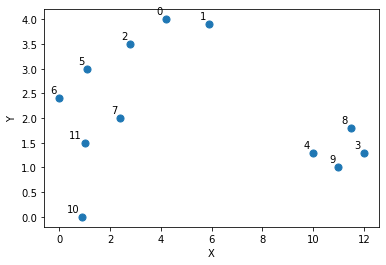

In [190]:
# plotting data
import matplotlib.pyplot as plt
plt.scatter(lacture.iloc[:, 0], lacture.iloc[:, 1], s=50, cmap='viridis')
plt.xlabel('X')
plt.ylabel('Y')

index = range(len(lacture))
for id, x, y in zip(index, lacture.iloc[:, 0], lacture.iloc[:, 1]):
    plt.annotate(
        id,
        xy=(x, y), xytext=(-3, 3),
        textcoords='offset points', ha='right', va='bottom')
plt.show()

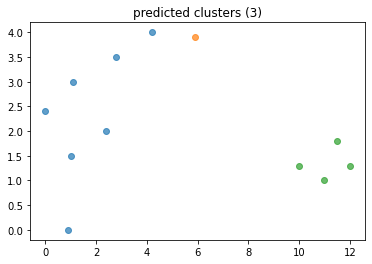

In [21]:
plot_cluster(mydata, ax1=False, ax2=True)

# 6) Results
For evaluation we will measure:
- **Computing Time**, and what parameters of the algorithm or the dataset that affects this
- **Visual Comparison**, plotting both the real and predicted clusters if they are in 2D. For higher dimension dataset, we'll use PCA to reduce them to 2 for visualizations
- internal evaluation (labeled/real clusters are not required) called the **Silhouette Coefficient** calculated using the mean intra-cluster distance `(a)` and the mean nearest-cluster distance `(b)` for each sample. The Silhouette Coefficient for a sample is $(b - a) / max(a, b)$. best value is 1, while the worst is -1

- external evaluation using **Rand Index** to compare similarity between real clusters and predicted clusters

[Reference from sk-learn](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation)

### Helper functions
Best to keep this collapsed because it's very long

In [ ]:
# prepare the df for evaluation metrics
def clean_df(df):
    # replace the 'NOISE' in predicted label with int to allow computation
    tot = len(df.ClId.unique())     # get total unique labels
    pred_c = df.iloc[:,-1]
    df['ClId'] = pred_c.replace('NOISE', tot)
    return df

# calculate silhouette score
def get_sil_score(df):
    df = clean_df(df)                   # replace 'NOISE' label with int to be computed
    X = df.iloc[:,:2].to_numpy()        # get the features only
    pred_c = df.iloc[:,-1].to_numpy()   # get predicted clusters
    if len(np.unique(pred_c)) < 2:      # if there's only 1 predicted cluster, the metric can't be computed
        return pd.NA
    else:
        return metrics.silhouette_score(X, pred_c, metric='euclidean')

# calculate rand index and adjusted rand index
def get_rand_index(df):
    df = clean_df(df)
    real_c = df.iloc[:,-2]
    pred_c = df.iloc[:,-1]
    ri = metrics.rand_score(real_c, pred_c)
    ari = metrics.adjusted_rand_score(real_c, pred_c)
    return ri, ari

# calculate Purity index
def get_purity_index(real_c, pred_c):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(real_c, pred_c)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 

# calculate Davies−Bouldin index
def get_davies_bouldin_index(X, pred_c):
    # compute davies bouldin index
    davies_bouldin_index = metrics.davies_bouldin_score(X, pred_c)
    # return davies bouldin index
    return davies_bouldin_index 

# one function to print all the metrics
def print_metric(df):
    ss = get_sil_score(df)
    ri, ari = get_rand_index(df)
    print(f'silhouette coefficient: {ss:.2f}')
    print(f'rand index: {ri:.2f}')
    print(f'adjusted rand index: {ari:.2f}')

In [ ]:
def eval_DBSCAN(df, Eps, MinPts, Name, TI=False):
    """ Function to experiment with different Eps and MinPts
    Eps and MinPts should be an array
    Name should match the variable name
    TI : if True then use triangle inequality
    Returns:
        dataframe of the algorithm results along with the plot
    """
    # plot configuration
    r = len(Eps)
    c = len(MinPts)
    np = r * c  # total num of plots
    i = 1  # counter for the plot

    
    # for results table
    t_list = []     # list of processing time
    eps_list = []   # list of epsilon
    mp_list = []    # list of MinPts
    nc_list = []    # num of predicted clusters
    ss_list = []    # silhouette score
    ri_list = []    # rand index
    ari_list = []   # adjusted rand index

    f = plt.figure(figsize=(5*c, 5*r))
    for _eps in Eps:
        for _minpts in MinPts:
            print(f'processing eps: {_eps} and minPts: {_minpts}')

            if TI:  # use TI-DBSCAN
                if 'ClId' in df.columns:
                    X = df.iloc[:,:-2].to_numpy()  # get features only
                else:
                    X = df.iloc[:,:-1].to_numpy()  # get features only
                t0 = time.time()               # measure clustering time
                result = TI_DBScan(X, _eps, _minpts)
                t1 = time.time()
                t = t1-t0
                df['ClId'] = [el.ClusterId for el in result]  # get predicted clusters and insert to dataframe

            else:  # use DBSCAN
                t = DBSCAN(df, Eps=_eps, MinPts=_minpts, Name=Name)
            
            # plotting
            ax = f.add_subplot(r,c,i)
            if df.shape[1]>4:            # if dimension of dataset > 4, use PCA to plot
                plot_high_d(df, ax2=ax)  # plot the prediction
            else: 
                plot_compare(df, ax2=ax) # plot the prediction
            i += 1

            nc = len(df.iloc[:,-1].unique())
            # overide the title name
            ax.set_title(f'eps: {_eps}, minPts: {_minpts}, found: {nc} clusters')
            
            # get metrics
            ss = get_sil_score(df)
            ri, ari = get_rand_index(df)
            
            # append for the database
            t_list.append(t)
            eps_list.append(_eps)
            mp_list.append(_minpts)
            nc_list.append(nc)
            ss_list.append(ss)
            ri_list.append(ri)
            ari_list.append(ari)

    # create a dataframe
    result_df = pd.DataFrame.from_dict({'Eps': eps_list, 'MinPts': mp_list, 'N_clusters': nc_list,
                                        'Time': t_list, 'S_score': ss_list, 'RI': ri_list, 'ARI': ari_list})
    
    if TI:
        result_df.to_csv(f'drive/MyDrive/dami/TI_DBSCAN_{Name}.csv', index=False)
    else:
        result_df.to_csv(f'drive/MyDrive/dami/{Name}.csv', index=False)

    return result_df

## 6.1 DBSCAN


### 6.1.1 Evaluation metric and algorithm parameters
Here we'll show each evaluation metrics and how certain parameters of the model affect them

**Computing time**

Despite `banana` having 3x larger size, `c20` dataset took longer time to process than `banana` dataset. This is because c20 has much larger epsilon value, making more neighborhood data points to consider

In [ ]:
tcomp = DBSCAN(c20, Eps=3, MinPts=30, Name='c20')
print(f'DBSCAN of c20, time: {tcomp:.1f}')
tcomp = DBSCAN(banana, Eps=0.01, MinPts=5, Name="banana")
print(f'DBSCAN of banana, time: {tcomp:.1f}')

DBSCAN of c20, time: 43.2
DBSCAN of banana, time: 29.1


**Silhouette Coefficient**


For `banana` the results were a large negative value, meaning most samples are assigned to the wrong cluster, and a different cluster is more similar. In contrast, `c20` obtained a good score.

In [ ]:
print(f'Silhouette coefficient banana: {get_sil_score(banana):.2f}')
print(f'Silhouette coefficient c20: {get_sil_score(c20):.2f}')

Silhouette coefficient banana: -0.62
Silhouette coefficient c20: 0.60


**Rand Index**
- measures similarity between real and predicted cluster labels
Despite most clusters are not assigned correctly, `banana` still has a good rand index score. This is because.. But when using the adjusted rand index, the score is lower, because..

`c20` yield almost perfect rand index

In [ ]:
ri, ari = get_rand_index(banana)
print(f'rand index banana: {ri:.2f}')
print(f'adjusted rand index banana: {ari:.2f}')

ri, ari = get_rand_index(c20)
print(f'rand index c20: {ri:.2f}')
print(f'adjusted rand index c20: {ari:.2f}')

rand index banana: 0.83
adjusted rand index banana: 0.65
rand index c20: 0.99
adjusted rand index c20: 0.92


#### large cardinality

processing eps: 0.4 and minPts: 1
processing eps: 0.4 and minPts: 2
processing eps: 0.6 and minPts: 1
processing eps: 0.6 and minPts: 2
processing eps: 0.8 and minPts: 1
processing eps: 0.8 and minPts: 2
processing eps: 1.0 and minPts: 1
processing eps: 1.0 and minPts: 2


,Eps,MinPts,N_clusters,Time,S_score,RI,ARI
0,0.4,1,125,1.081542,-0.463570,0.999080,0.943982
1,0.4,2,68,0.244892,-0.663447,0.841737,0.064193
2,0.6,1,116,0.281512,-0.505800,1.000000,1.000000
3,0.6,2,71,0.258276,-0.671509,0.881027,0.095335
4,0.8,1,116,0.287055,-0.505800,1.000000,1.000000
5,0.8,2,70,0.269794,-0.670523,0.881165,0.097316
6,1.0,1,116,0.277620,-0.505800,1.000000,1.000000
7,1.0,2,69,0.284672,-0.668876,0.881303,0.099292


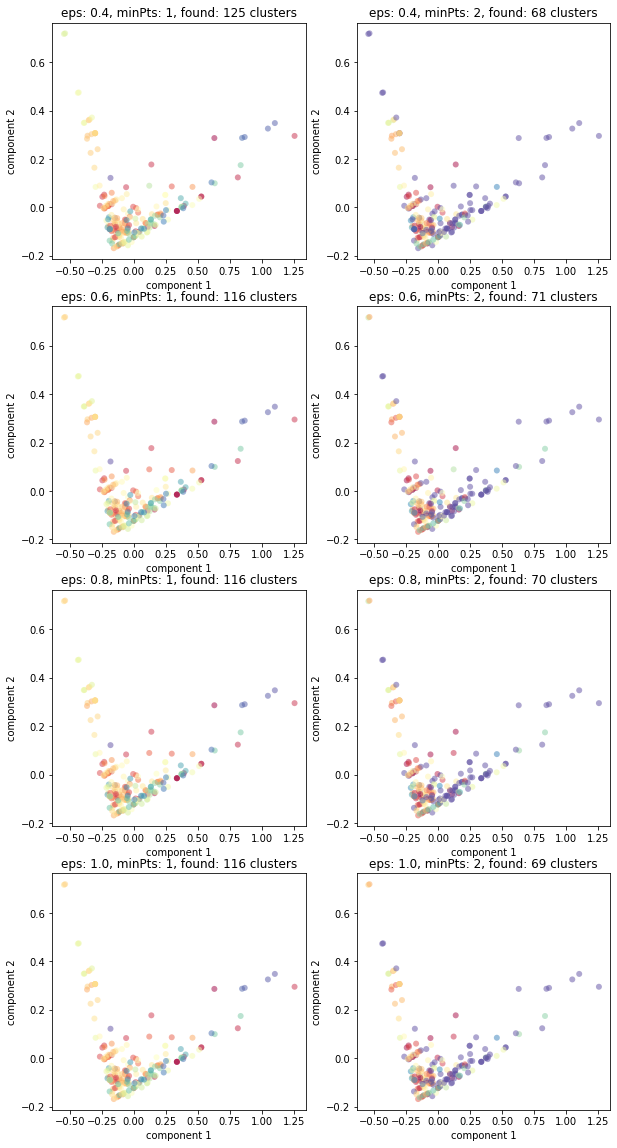

In [ ]:
cpu_df = eval_DBSCAN(cpu, Eps=[0.4, 0.6, 0.8, 1.0], MinPts=[1,2], Name='cpu')
display(cpu_df)

processing eps: 2 and minPts: 20
processing eps: 2 and minPts: 30
processing eps: 2 and minPts: 40
processing eps: 3 and minPts: 20
processing eps: 3 and minPts: 30
processing eps: 3 and minPts: 40
processing eps: 4 and minPts: 20
processing eps: 4 and minPts: 30
processing eps: 4 and minPts: 40


,Eps,MinPts,N_clusters,Time,S_score,RI,ARI
0,2,20,21,38.716388,0.655830,0.999850,0.998538
1,2,30,20,36.916533,0.653392,0.999794,0.997999
2,2,40,18,34.217141,0.600416,0.996006,0.962194
3,3,20,19,39.731947,0.597073,0.991058,0.919460
4,3,30,19,39.501427,0.597073,0.991058,0.919460
5,3,40,18,38.749810,0.589200,0.990398,0.913970
6,4,20,13,37.048392,0.325990,0.953281,0.677094
7,4,30,14,37.757749,0.335185,0.958330,0.702745
8,4,40,13,38.370670,0.338975,0.957670,0.699298


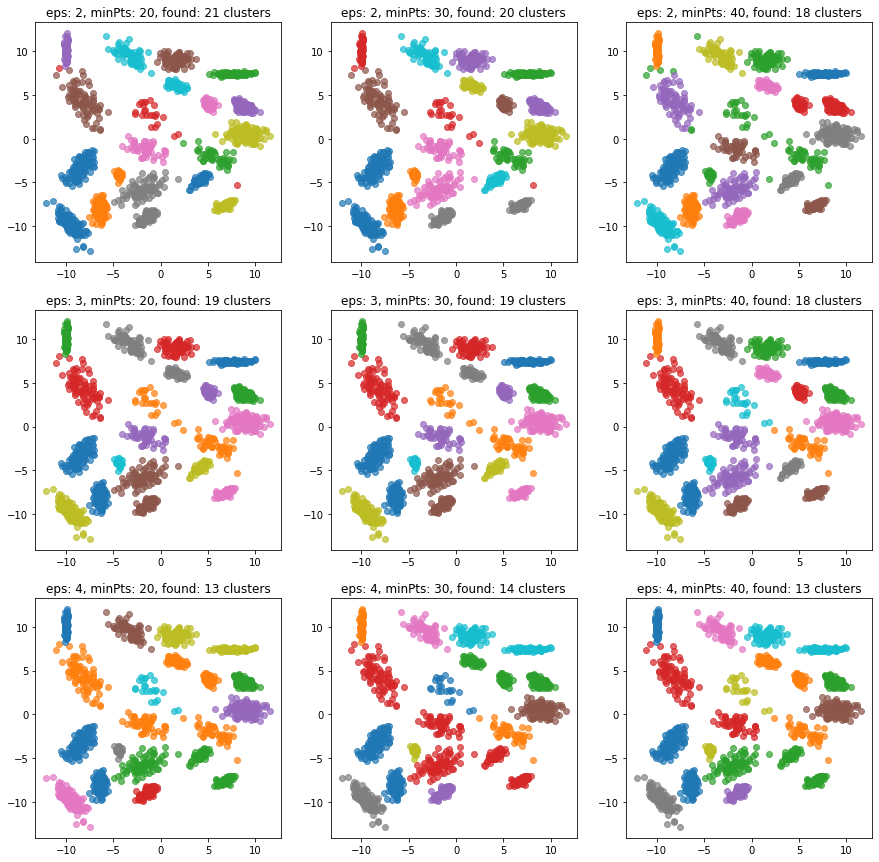

In [ ]:
c20_df = eval_DBSCAN(c20, Eps=[2, 3, 4], MinPts=[20,30,40], Name='c20')
display(c20_df)

#### large everything

processing eps: 4.5 and minPts: 30
processing eps: 4.5 and minPts: 40
processing eps: 4.5 and minPts: 50
processing eps: 5.0 and minPts: 30
processing eps: 5.0 and minPts: 40
processing eps: 5.0 and minPts: 50
processing eps: 5.5 and minPts: 30
processing eps: 5.5 and minPts: 40
processing eps: 5.5 and minPts: 50


,Eps,MinPts,N_clusters,Time,S_score,RI,ARI
0,4.5,30,20,469.828330,-0.499907,0.538480,0.026416
1,4.5,40,13,444.574516,-0.275863,0.562630,0.026619
2,4.5,50,16,402.386569,-0.279462,0.625932,0.032167
3,5.0,30,10,479.154417,-0.336591,0.354042,0.013598
4,5.0,40,10,472.031589,-0.236298,0.465042,0.022441
5,5.0,50,10,457.821378,-0.212022,0.491561,0.022914
6,5.5,30,4,590.819869,0.119752,0.087320,0.000191
7,5.5,40,4,587.063730,-0.240610,0.140707,0.000655
8,5.5,50,5,575.956437,-0.162554,0.224064,0.005619


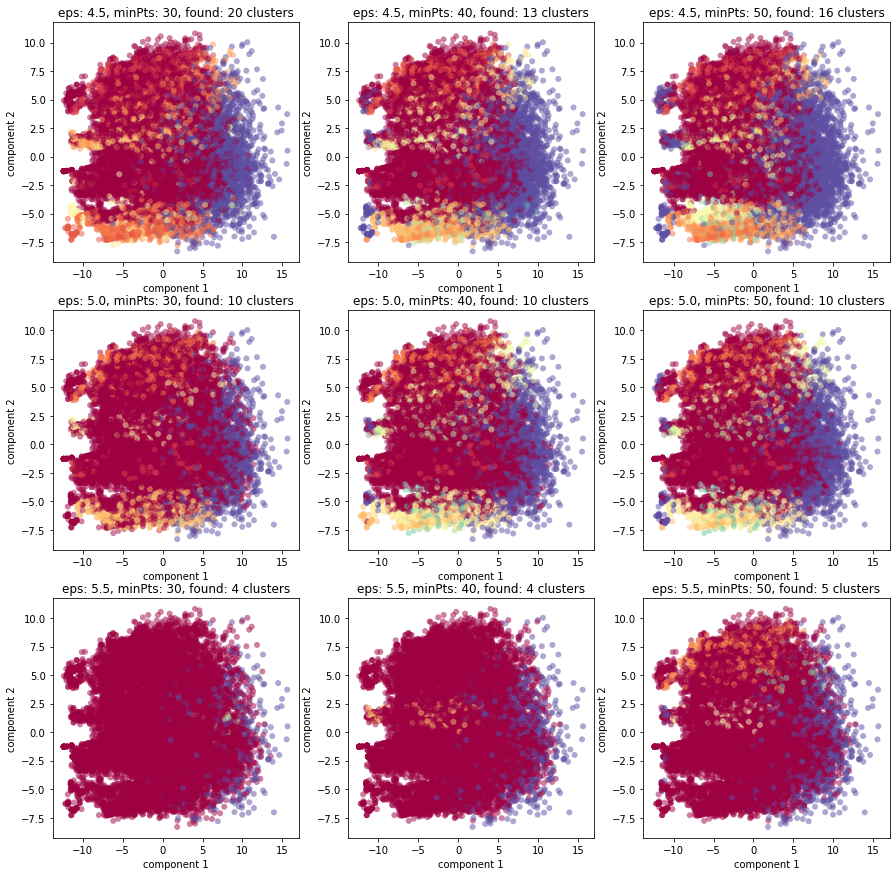

In [ ]:
letter_df = eval_DBSCAN(letter, Eps=[4.5, 5.0, 5.5], MinPts=[30,40,50], Name='letter')
display(letter_df)

#### unsupervised
Unfortunately, the implemented DBSCAN can't be used on any birch dataset because there's not enough RAM (exceeds the 12.7 GB limit of this cloud notebook)

In [ ]:
letter_df = eval_DBSCAN(birch1, Eps=[0.01], MinPts=[10], Name='birch1')

### 6.1.4 Results
Here we average all metrics score and grab the highest from each dataset experiment. This is the result of DBSCAN algorithm on the selected datasets

In [ ]:
# take the best results from experiments with all datasets
ds_list = ['banana', 'disk', 'iono', 'sonar', 'cpu', 'c20', 'letter']
row_list = []
for ds_name in ds_list:
    df = pd.read_csv(f'drive/MyDrive/dami/{ds_name}.csv')
    # average the 3 metrics
    df['total'] = (df['S_score']+df['RI']+df['ARI'])/3
    # grab the row with max total score
    row_list.append(df.loc[df['total'].idxmax()])
    
results = pd.DataFrame(row_list)

# insert in the first column the dataset names
results.insert(loc=0, column='Dataset', value=ds_list)
# reset the row index
results.reset_index(drop=True, inplace=True)
results

,Dataset,Eps,MinPts,N_clusters,Time,S_score,RI,ARI,total
0,banana,0.05,5.0,2.0,181.091102,0.367331,1.000000,1.000000,0.789110
1,disk,0.90,5.0,2.0,332.716792,-0.063279,1.000000,1.000000,0.645574
2,iono,1.70,5.0,2.0,2.757433,0.494548,0.843223,0.682451,0.673407
3,sonar,1.70,10.0,2.0,3.435071,0.491906,0.498746,-0.002240,0.329471
4,cpu,0.60,1.0,116.0,0.281512,-0.505800,1.000000,1.000000,0.498067
5,c20,1.00,10.0,21.0,18.802758,0.624271,0.996676,0.967445,0.862798
6,letter,4.50,50.0,16.0,402.386569,-0.279462,0.625932,0.032167,0.126212


## 6.2 TI-DBSCAN


### 6.2.1 Experiments
In our experiments, TI-DBSCAN is much more sensitive to epsilon change. We need smaller epsilon and larger minPts to obtain

processing eps: 0.1 and minPts: 10
processing eps: 0.1 and minPts: 15
processing eps: 0.1 and minPts: 20
processing eps: 0.1 and minPts: 35
processing eps: 0.25 and minPts: 10
processing eps: 0.25 and minPts: 15
processing eps: 0.25 and minPts: 20
processing eps: 0.25 and minPts: 35
processing eps: 0.5 and minPts: 10
processing eps: 0.5 and minPts: 15
processing eps: 0.5 and minPts: 20
processing eps: 0.5 and minPts: 35
processing eps: 1.0 and minPts: 10
processing eps: 1.0 and minPts: 15
processing eps: 1.0 and minPts: 20
processing eps: 1.0 and minPts: 35
processing eps: 1.5 and minPts: 10
processing eps: 1.5 and minPts: 15
processing eps: 1.5 and minPts: 20
processing eps: 1.5 and minPts: 35


,Eps,MinPts,N_clusters,Time,S_score,RI,ARI
0,0.10,10,1,0.176425,<NA>,0.054498,0.000000
1,0.10,15,1,0.179172,<NA>,0.054498,0.000000
2,0.10,20,1,0.170502,<NA>,0.054498,0.000000
3,0.10,35,1,0.172096,<NA>,0.054498,0.000000
4,0.25,10,17,0.379387,-0.450586,0.585702,0.053857
5,0.25,15,9,0.400943,-0.360945,0.402976,0.029160
6,0.25,20,5,0.388504,-0.313574,0.222561,0.010234
7,0.25,35,1,0.416788,<NA>,0.054498,0.000000
8,0.50,10,18,0.700757,-0.0103115,0.923292,0.424561
9,0.50,15,17,0.723972,-0.0707898,0.881776,0.295310


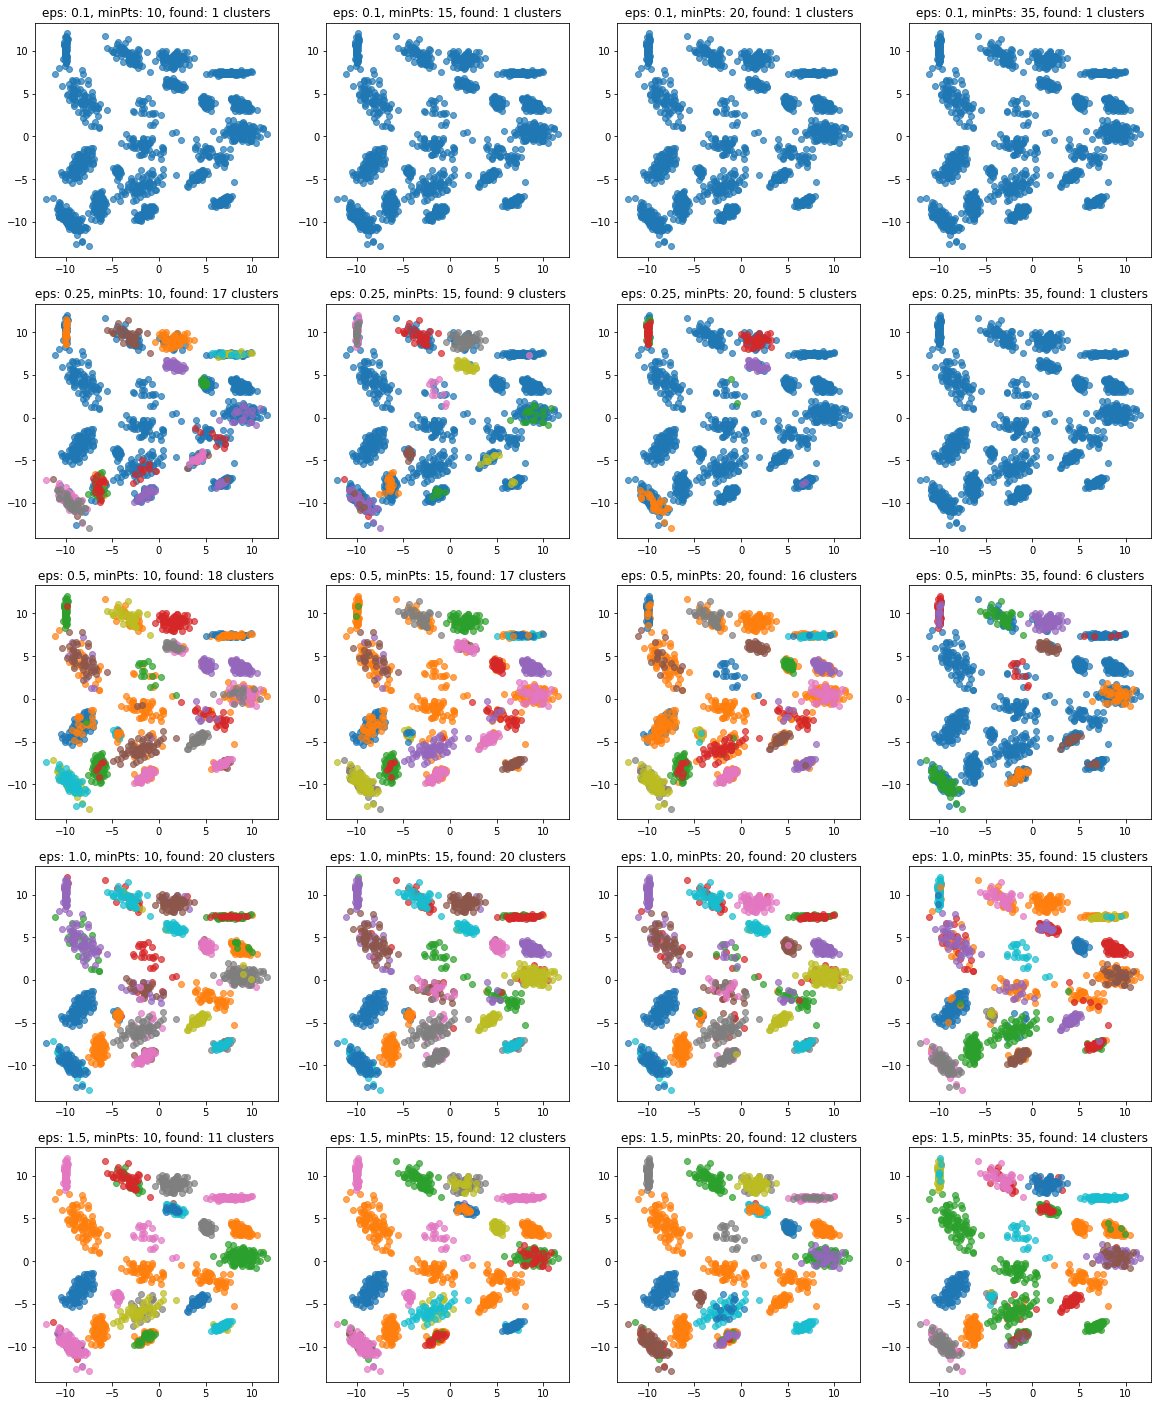

In [ ]:
c20_df = eval_DBSCAN(c20, Eps=[0.1, 0.25, 0.5, 1.0, 1.5], MinPts=[10,15,20,35], Name='c20', TI=True)
display(c20_df)

### 6.2.2 Results
Using the same parameters as in DBSCAN, we got the following results

processing eps: 0.05 and minPts: 5
processing eps: 0.9 and minPts: 5
processing eps: 1.7 and minPts: 5
processing eps: 1.7 and minPts: 10
processing eps: 0.6 and minPts: 1
processing eps: 2 and minPts: 20


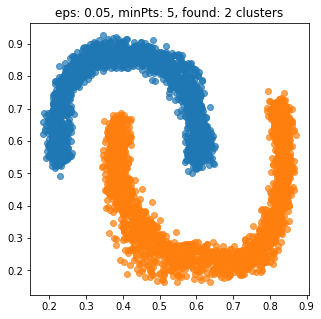

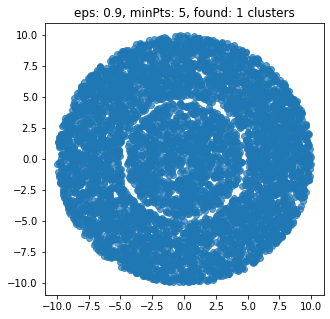

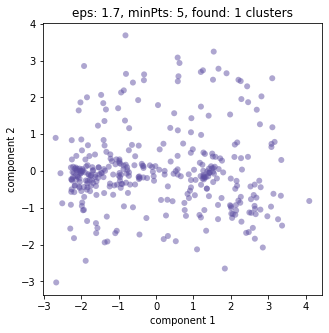

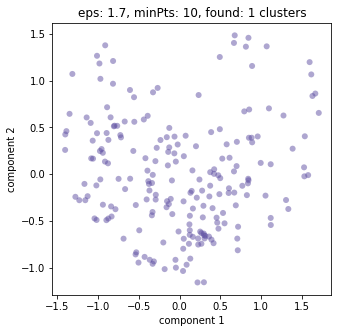

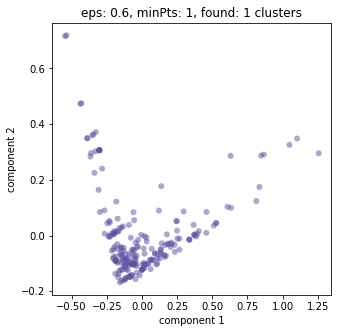

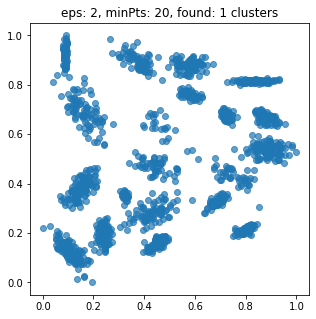

In [ ]:
banana_df = eval_DBSCAN(banana, [0.05], [5], 'banana', TI=True)
disk_df = eval_DBSCAN(disk, [0.9], [5], 'disk', TI=True)
iono_df = eval_DBSCAN(iono, [1.7], [5], 'iono', TI=True)
sonar_df = eval_DBSCAN(sonar, [1.7], [10], 'sonar', TI=True)
cpu_df = eval_DBSCAN(cpu, [0.6], [1], 'cpu', TI=True)
c20_df = eval_DBSCAN(c20, [2], [20], 'c20', TI=True)

In [ ]:
ds_list = ['banana', 'disk', 'iono', 'sonar', 'cpu', 'c20']
# take the best results from experiments with all datasets
row_list = []
for ds_name in ds_list:
    df = pd.read_csv(f'drive/MyDrive/dami/TI_DBSCAN_{ds_name}.csv')
    row_list.append(df.loc[0,:])
    
results_TI = pd.DataFrame(row_list)

# insert in the first column the dataset names
results_TI.insert(loc=0, column='Dataset', value=ds_list)
# reset the row index
results_TI.reset_index(drop=True, inplace=True)
results_TI

,Dataset,Eps,MinPts,N_clusters,Time,S_score,RI,ARI
0,banana,0.05,5.0,2.0,21.557352,0.367331,1.000000,1.0
1,disk,0.90,5.0,1.0,17.154585,NaN,0.679947,0.0
2,iono,1.70,5.0,1.0,0.593608,NaN,0.538462,0.0
3,sonar,1.70,10.0,1.0,0.261560,NaN,0.499861,0.0
4,cpu,0.60,1.0,1.0,0.265220,NaN,0.008741,0.0
5,c20,2.00,20.0,1.0,11.456157,NaN,0.054498,0.0


### 6.2.3 DBSCAN vs TI-DBSCAN
A side by side comparison of DBSCAN and TI-DBSCAN, it is proven that the TI property can reduce computation time up to 1/10th of original DBSCAN.

An exception for high cardinality dataset like `cpu` that has 116 classes, TI-DBSCAN took slightly longer than DBSCAN, most likely because the parameters Epsilon and MinPts are tweaked to find a high number of clusters.

For `letter`, we had a problem where the algorithm could not converge.

# 8) Reference

[1] Kryszkiewicz M., Lasek P. (2010) A Neighborhood-Based Clustering by Means of the Triangle Inequality. In: Fyfe C., Tino P., Charles D., Garcia-Osorio C., Yin H. (eds) Intelligent Data Engineering and Automated Learning – IDEAL 2010. IDEAL 2010

[2] Han, J., Kamber, M., & Pei, J. (2012). Data mining: Concepts and techniques, third edition (3rd ed.). Morgan Kaufmann Publishers.

[3] Marzena  Kryszkiewicz  and  Piotr  Lasek.  “A  Neighborhood-Based  Clus-tering  by  Means  of  the  Triangle  Inequality”.  In:Proceedings  of  the  11thInternational  Conference  on  Intelligent  Data  Engineering  and  AutomatedLearning. IDEAL’10. Paisley, UK: Springer-Verlag, 2010, pp. 284–291.isbn:3642153801.

[4] Marzena  Kryszkiewicz  and  Piotr  Lasek.  “TI-DBSCAN:  Clustering  withDBSCAN by Means of the Triangle Inequality”. In:Rough Sets and CurrentTrends  in  Computing.  Ed.  by  Marcin  Szczuka  et  al.  Berlin,  Heidelberg:Springer Berlin Heidelberg, 2010, pp. 60–69.isbn: 978-3-642-13529-3.